# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Загрузим библиотеки для дальнейшей работы

In [3]:
kvart = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') # Откроем файл и поставим разделитель(табуляция)
#print(kvart.head(20)) # Смотрим таблицу, видим большое количество пропусков

In [4]:
#kvart.describe() # Находим данные о том, что существуют квартиры с 19 комнатами, потолками в 1 и 100 метров

In [5]:
#kvart.info() # Смотрим общие данные по таблице

### Вывод

В таблице содержится 23699 строк. Очень много пропусков.
Некоторые столбцы содержат некорректные типы данных.

### Шаг 2. Предобработка данных

In [6]:
kvart['floors_total'].unique()
kvart['floors_total'] = kvart['floors_total'].astype('Int64') # Проверяем данные столбца с этажами и меняем тип данных

In [7]:
kvart['balcony'].unique()
kvart['balcony'] = kvart['balcony'].fillna(0)
kvart['balcony'] = kvart['balcony'].astype('Int64') # Проверяем данные столбца с балконами,там где данных нет
                                                    # скорее всего нет балконов = 0. Меняем тип данных

In [8]:
kvart['is_apartment'].value_counts() # Должен быть булев тип, проверяем

False    2725
True       50
Name: is_apartment, dtype: int64

In [9]:
kvart['is_apartment'].replace('True', True)
kvart['is_apartment'].replace('False', False)
kvart['is_apartment'] = kvart['is_apartment'].fillna(False)
kvart['is_apartment'] = kvart['is_apartment'].astype('bool')
kvart['is_apartment'].value_counts() # Скорее всего незаполненные данные являются апартаментами, заменяем значения, меняем тип данных

False    23649
True        50
Name: is_apartment, dtype: int64

In [10]:
kvart['studio'].value_counts() # Всё оки

False    23550
True       149
Name: studio, dtype: int64

In [11]:
kvart['days_exposition'] = kvart['days_exposition'].round()
kvart['days_exposition'] = kvart['days_exposition'].astype('Int64') # Округляем количество дней жизни и меняем тип данных

*Проверим все столбцы подряд, чтобы выявить данные которые отсутствуют или некорректны.*

In [12]:
kvart['total_images'].unique() 

array([20,  7, 10,  0,  2,  6,  5, 18,  9,  1, 16, 11,  8, 12, 13,  3, 15,
       17, 14, 19, 32,  4, 35, 39, 23, 21, 27, 30, 24, 25, 28, 31, 22, 29,
       26, 50, 42, 37])

In [13]:
kvart['last_price'].describe(percentiles=[.01, .1, .5, .9, .99]).round() # Поставим перцентили в 1% и 10% с нижней и верхней границы, чтобы узнать данные, которые можно считать выбросами

count        23699.0
mean       6541549.0
std       10887013.0
min          12190.0
1%         1000000.0
10%        2500000.0
50%        4650000.0
90%       10914231.0
99%       36000000.0
max      763000000.0
Name: last_price, dtype: float64

*Верхняя и нижняя граница явно некорректны. Медиана находится в пределах нормы*

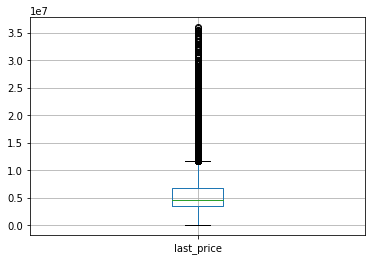

In [14]:
kvart[kvart['last_price']<36000000].boxplot(column=['last_price']) # Смотрим графические данные

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c6b02d690>]],
      dtype=object)

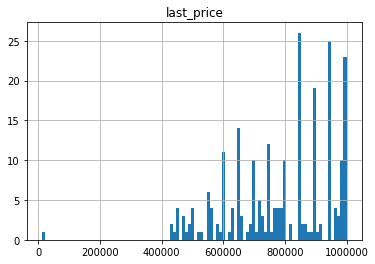

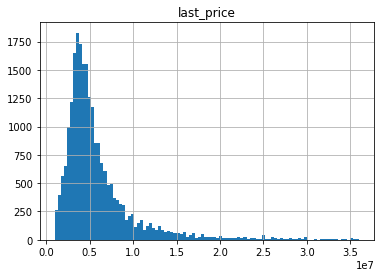

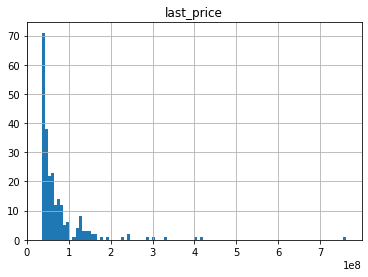

In [15]:
kvart.hist('last_price', bins=100, range=(kvart['last_price'].min(),10**6))
kvart.hist('last_price', bins=100, range=(10**6,36000000))
kvart.hist('last_price', bins=100, range=(36000000, kvart['last_price'].max()))

*Снизу есть явно некорректное значение - 12190р. Далее, несмотря на редкие значения, распределение нормальное с 400 тысяч до 100 млн рублей. Квартиры свыше 100 млн отбросим. Поэтому для нормализации данных по столбцу цены можно оставить данные в пределах 1,5 межквартильного размаха от 1 и 3 квартиля. Перед этим удалим одно минимальное значение, которое попадает внутрь этого размаха, но явно некорректно.*

In [16]:
kvart = kvart[kvart['last_price'] > 20000]

q1 = kvart['last_price'].quantile(0.25)
q3 = kvart['last_price'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr
print(lower_limit, q1, q3, iqr, upper_limit)
kvart = kvart.query('last_price > @lower_limit and last_price < @upper_limit ')

-1700000.0 3400000.0 6800000.0 3400000.0 11900000.0


In [17]:
#kvart.info() 
# Было 23699 строк, стало 21637

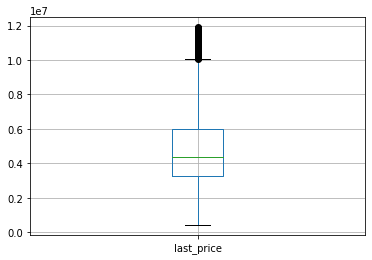

In [18]:
kvart.boxplot(column=['last_price'])

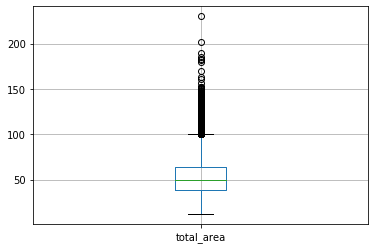

In [19]:
kvart.boxplot(column=['total_area'])

Несмотря на то, что у данных площади квартир длинный хвост, все значения находятся в пределах нормальных и объяснимых. Квартиры площадью больше 200 метров также должны укладываться в модель формирования стоимости, поэтому оставляем все значения без изменений.

In [20]:
kvart[kvart['total_area'] < kvart['living_area'] + kvart['kitchen_area']]['kitchen_area'].count() 
# Проверяем, что сумма жилой площади и площади кухни не превышает общую площадь квартиры

61

In [21]:
kvart.drop(kvart[kvart['total_area'] < kvart['living_area'] + kvart['kitchen_area']].index, inplace=True) 
# Доля таких квартир очень мала, поэтому удаляем их

In [22]:
#kvart['living_area'] = kvart['living_area'].fillna(0)
#kvart['kitchen_area'] = kvart['kitchen_area'].fillna(0) # Заполним пропущенные значения нулями, т.к. кухни может и не быть

In [23]:
kitchen_area_avg = kvart['kitchen_area'].mean()
kvart['kitchen_area_good'] = kvart['kitchen_area'].fillna(kitchen_area_avg) 

In [24]:
kvart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21576 entries, 1 to 23698
Data columns (total 23 columns):
total_images            21576 non-null int64
last_price              21576 non-null float64
total_area              21576 non-null float64
first_day_exposition    21576 non-null object
rooms                   21576 non-null int64
ceiling_height          13049 non-null float64
floors_total            21502 non-null Int64
living_area             19888 non-null float64
floor                   21576 non-null int64
is_apartment            21576 non-null bool
studio                  21576 non-null bool
open_plan               21576 non-null bool
kitchen_area            19502 non-null float64
balcony                 21576 non-null Int64
locality_name           21533 non-null object
airports_nearest        16094 non-null float64
cityCenters_nearest     16105 non-null float64
parks_around3000        16106 non-null float64
parks_nearest           6706 non-null float64
ponds_around3000    

In [25]:
kvart['first_day_exposition'] = pd.to_datetime(kvart['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# Столбец даты приводим к типу datetime

In [26]:
kvart['rooms'].value_counts() # Возможно квартиры с 0 комнатами это студии, проверим далее

1    7975
2    7579
3    4934
4     758
0     195
5     118
6      16
7       1
Name: rooms, dtype: int64

In [27]:
kvart.pivot_table (index = ['rooms'], columns = 'studio', values = 'total_images', aggfunc='count') 
# Данные заполнены некорректно, все квартиры с 0 кол-вом комнат это студии, studio = True тоже студии

studio,False,True
rooms,,
0,58.0,137.0
1,7964.0,11.0
2,7579.0,NaN
3,4934.0,NaN
4,758.0,NaN
5,118.0,NaN
6,16.0,NaN
7,1.0,NaN


In [28]:
kvart.loc[(kvart['rooms'] == 0) & (kvart['studio'] == False), 'studio'] = True
kvart.loc[(kvart['studio'] == True) & (kvart['rooms'] == 0), 'rooms'] = 1
# Исправили данные

In [29]:
kvart.pivot_table (index = ['rooms'], columns = 'studio', values = 'total_images', aggfunc='count')

studio,False,True
rooms,,
1,7964.0,206.0
2,7579.0,NaN
3,4934.0,NaN
4,758.0,NaN
5,118.0,NaN
6,16.0,NaN
7,1.0,NaN


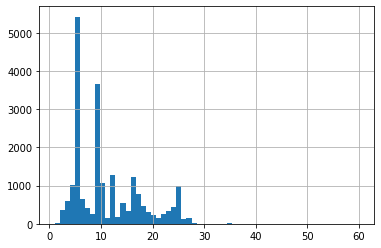

In [30]:
kvart['floors_total'].hist(bins=kvart['floors_total'].max())

*Как мы все знаем, в Питере много пяти и девятиэтажек, в целом, распределение нормальное. Самое высокое здание по данным вики это ЖК «Князь Александр Невский» - 37 этажей.*

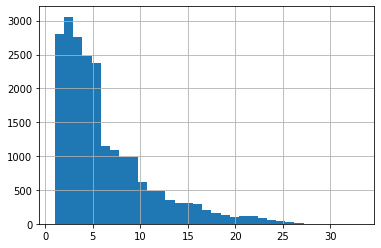

In [31]:
kvart['floor'].hist(bins=kvart['floor'].max())

*Распределение floor нормальное.*

In [32]:
kvart[kvart['floors_total'] < kvart['floor']]['floor'].count() # Ни для одной квартиры этаж не превышает этажность дома.

0

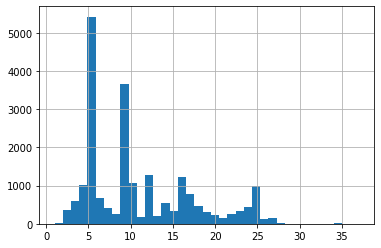

In [33]:
kvart['floors_total'] = np.where(kvart['floors_total'] > 37, kvart['floor'], kvart['floors_total'])
kvart['floors_total'] = np.where(kvart['floors_total'].isnull(), kvart['floor'], kvart['floors_total'])
kvart['floors_total'].hist(bins=kvart['floors_total'].max()) #Заменяем пропущенные значения floors_total

In [34]:
kvart['ceiling_height'].round().value_counts().sort_values() # Значения выше 6 метров скорее всего некорректны

23.0       1
10.0       1
20.0       1
14.0       1
26.0       1
6.0        1
24.0       1
1.0        2
32.0       2
5.0        3
8.0        4
27.0       7
25.0       7
4.0      194
2.0     3547
3.0     9276
Name: ceiling_height, dtype: int64

In [35]:
kvart[kvart['ceiling_height']<2.5]['ceiling_height'].value_counts().sort_values() # Проверяем нижние значения

2.20     1
1.20     1
2.49     1
2.34     1
1.00     1
2.25     1
1.75     1
2.46     2
2.47     3
2.30     4
2.48     8
2.00    10
2.45    15
2.40    23
Name: ceiling_height, dtype: int64

*Думаю что оптимальная высота потолков от 2 до 6 метров. В столбце есть пропущенные значения. Будем работать с ними.*

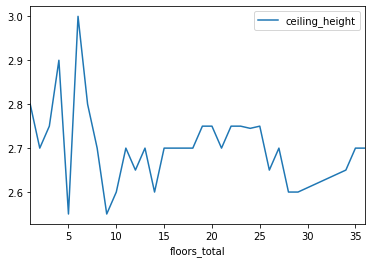

In [36]:
(kvart.query('ceiling_height >= 2 & ceiling_height <= 6')
 .pivot_table(index = ['floors_total'], values = 'ceiling_height', aggfunc = 'median')
 .plot(kind = 'line'))
# Определяем отличия высоты потолков в зависимости от высоты здания

Основные группы зданий:
1. 5 и 9 этажки с высотой потолков 2.5 метра
2. Низкие здания с очень высокими потолками (Исторический центр Питера)
3. Новые здания выше 10 этажей, с высотой потолков не более 2.8 метров

*Далее заменим пропущенные и некорректные значения высоты потолков на медианные значения каждой группы домов одинаковой этажности*

In [37]:
med_ceiling_general = kvart.query('ceiling_height >= 2 & ceiling_height<=6')['ceiling_height'].median()

for floor in range (kvart['floors_total'].min(), kvart['floors_total'].max()+1):
# если есть хотя бы одно объявление с выбранным количеством этажей и нормальной высотой полотков:
    if len(kvart.query('floors_total == @floor & ceiling_height >= 2 & ceiling_height<=6'))>0:
# исправляем неправильную высоту потолков на медиану для каждой группы домов одинаковой этажности:
        med_ceiling_per_floor = kvart.query('floors_total == @floor & ceiling_height >= 2 & ceiling_height<=6')['ceiling_height'].median()
        kvart.loc[(kvart['floors_total'] == floor) & (kvart['ceiling_height'] < 2), 'ceiling_height'] = med_ceiling_per_floor
        kvart.loc[(kvart['floors_total'] == floor) & (kvart['ceiling_height'] > 6), 'ceiling_height'] = med_ceiling_per_floor
        kvart.loc[(kvart['floors_total'] == floor) & (kvart['ceiling_height'].isnull()), 'ceiling_height'] = med_ceiling_per_floor
# если объявлений с выбранным количеством этажей и нормальной высотой полотков нет,
    else:
# исправляем неправильную высоту потолков на общую медиану:
        kvart.loc[(kvart['floors_total'] == floor) & (kvart['ceiling_height'] < 2), 'ceiling_height'] = med_ceiling_general
        kvart.loc[(kvart['floors_total'] == floor) & (kvart['ceiling_height'] > 6), 'ceiling_height'] = med_ceiling_general
        kvart.loc[(kvart['floors_total'] == floor) & (kvart['ceiling_height'].isnull()), 'ceiling_height'] = med_ceiling_general

In [38]:
#print(len(kvart[kvart['ceiling_height']<2]))
#print(len(kvart[kvart['ceiling_height']>6]))
#print(kvart['ceiling_height'].isnull().sum()) # Проверка отсутствия пустых и некорректных значений

In [39]:
kvart['ceiling_height'].round().value_counts().sort_values(ascending = False)

3.0    17832
2.0     3546
4.0      194
5.0        3
6.0        1
Name: ceiling_height, dtype: int64

In [40]:
#kvart['locality_name'].value_counts().head(10)

In [41]:
kvart['locality_name'] = kvart['locality_name'].str.strip()

statuses = ['поселок ', 'посёлок ', 'коттеджный поселок', 'коттеджный посёлок', 'деревня ', 
            'городской ', 'городского типа ', 'садовое товарищество ', 'село ']
for status in statuses:
    kvart['locality_name'] = kvart['locality_name'].str.replace(status, '')
kvart['locality_name'].value_counts().head(10) 
# Статусы населённых пунктов вынесем в отдельный столбец, чтобы избежать различных написаний пунктов

Санкт-Петербург    13700
Мурино               587
Кудрово              470
Шушары               439
Всеволожск           394
Пушкин               338
Колпино              335
Парголово            326
Гатчина              301
Выборг               236
Name: locality_name, dtype: int64

43


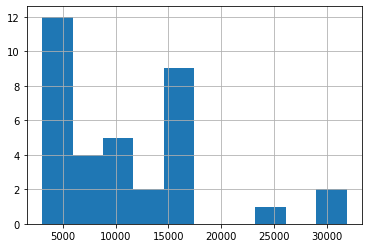

In [42]:
print(kvart[kvart['locality_name'].isnull()]['total_images'].count())
kvart[kvart['locality_name'].isnull()]['cityCenters_nearest'].hist() # Смотрим пропущенные значения

In [43]:
kvart.dropna(subset = ['locality_name'], inplace = True)
# Удаляем пропуски, т.к. нельзя определить к какому городу относятся пропуски

Количество пропущенных значений: 5474


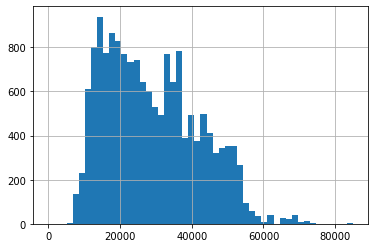

In [44]:
kvart['airports_nearest'].hist(bins = 50)
print('Количество пропущенных значений: {:.0f}'.format(kvart[kvart['airports_nearest'].isnull()]['total_images'].count()))

In [45]:
kvart[kvart['airports_nearest'] > 60000]['locality_name'].value_counts() 
# Смотрим квартиры, которые удалены на 60 км от аэропорта

Кронштадт      94
Парголово      30
Зеленогорск    22
Сестрорецк     14
Молодёжное      5
Репино          3
Щеглово         1
Name: locality_name, dtype: int64

In [46]:
kvart[kvart['airports_nearest'].isnull()]['locality_name'].value_counts()
# Смотрим пропущенные значения

Мурино         585
Кудрово        470
Всеволожск     394
Гатчина        301
Выборг         236
              ... 
Каложицы         1
Рапполово        1
Хязельки         1
Кондратьево      1
Сижно            1
Name: locality_name, Length: 290, dtype: int64

*Пропущенные значения есть только для отдельных населенных пунктов. Вероятно, заполнить их можно будет так же, как и пропущенные значения расстояния до центра города, поэтому переходим к нему.*

Количество пропущенных значений: 5463


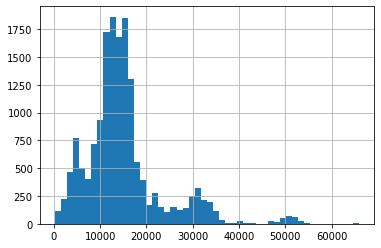

In [47]:
kvart['cityCenters_nearest'].hist(bins = 50)
print('Количество пропущенных значений: {:.0f}'.format(kvart[kvart['cityCenters_nearest'].isnull()]['total_images'].count()))

In [48]:
kvart[kvart['cityCenters_nearest'].isnull()]['locality_name'].value_counts()
# Пропуски по большей части совпадают

Мурино                        585
Кудрово                       470
Всеволожск                    394
Гатчина                       301
Выборг                        236
                             ... 
Алексеевка                      1
Пушкин                          1
Русско                          1
коттеджный Кивеннапа Север      1
коттеджный Лесное               1
Name: locality_name, Length: 291, dtype: int64

In [49]:
localities_NaN_airport_center = (
    kvart.query('airports_nearest != airports_nearest and cityCenters_nearest != cityCenters_nearest')
    ['locality_name'].unique())
print(len(localities_NaN_airport_center))
print(len((
    kvart[(kvart['locality_name'].isin(localities_NaN_airport_center)) 
    & (kvart['airports_nearest'].notnull())]['locality_name'].unique())))
print(len((
    kvart[(kvart['locality_name'].isin(localities_NaN_airport_center)) 
    & (kvart['cityCenters_nearest'].notnull())]['locality_name'].unique())))
print((
    kvart[(kvart['locality_name'].isin(localities_NaN_airport_center)) 
    & (kvart['airports_nearest'].notnull())]['locality_name'].unique()))

290
8
8
['Шушары' 'Санкт-Петербург' 'Ломоносов' 'Колпино' 'Кронштадт'
 'Красное Село' 'Щеглово' 'Мурино']


*Для квартир в 290 населенных пунктах не указано расстояние до центра аэропорта и центра города. Только в 8 из них есть другие квартиры и эти населенные пункты совпадают и для расстояния до центра города, и для аэропорта. Восстановить эти данные на основе данных датасета нельзя, заполнять другими значениями нет смысла, потому что они будут искажать выводы при анализе влияния расстояния до центра на остальные параметры. Чтобы пропущенные данные не влияли на расчеты, оставляем их в формате NaN.*

In [50]:
kvart[kvart['parks_nearest'].isnull()]['parks_around3000'].value_counts() 
# Скорее всего пропущенные значения означают, что парка рядом нет

0.0    9375
Name: parks_around3000, dtype: int64

In [51]:
kvart[kvart['ponds_nearest'].isnull()]['ponds_around3000'].value_counts() 
# Скорее всего пропущенные значения означают, что водоёма рядом нет

0.0    8334
Name: ponds_around3000, dtype: int64

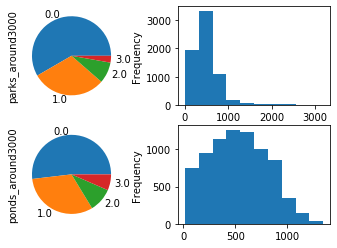

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2)
kvart['parks_around3000'].value_counts().plot(kind='pie', ax=axes[0, 0]);
kvart['parks_nearest'].plot(kind='hist', ax=axes[0, 1]);
kvart['ponds_around3000'].value_counts().plot(kind='pie', ax=axes[1, 0]);
kvart['ponds_nearest'].plot(kind='hist', ax=axes[1, 1]);
# Значения в целом корректны, водоёмов явно больше парков(Питер, что тут поделать), 
# большинство водоёмов находится ближе чем 1.5км

Количество пропущенных значений: 2628


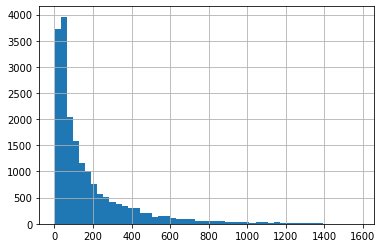

In [53]:
kvart['days_exposition'].hist(bins = 50)
print('Количество пропущенных значений: {:.0f}'.format(kvart[kvart['days_exposition'].isnull()]['total_images'].count()))

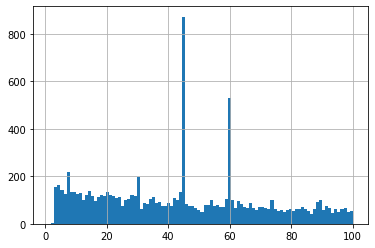

In [54]:
kvart[kvart['days_exposition'] <= 100]['days_exposition'].hist(bins = 100)

In [55]:
kvart.groupby('days_exposition')['days_exposition'].count().sort_values(ascending=False).head()

days_exposition
45    872
60    531
7     220
30    197
4     164
Name: days_exposition, dtype: int64

*Преобладание данных цифр очень подозрительно, зачастую сайты устанавливают срок снятия объявления и он равен месяцу, полтора и двум. При этом неизвестно, объявление было удалено автоматически, так как его владелец не смог продать квартиру и забыл про него (в этом случае срок продажи дольше жизни объявления), или, наоборот, продал квартиру до автоматического удаления (то есть срок продажи меньше срока жизни объявления), поэтому нельзя заменить пиковые значения на другие. Строки с топовыми значениями можно удалить из популяции, но время закрытия объявления не является одним из основных параметров, поэтому сокращение таблицы более чем на тысячу строк ради этого столбца неоправданно. Поэтому сделаем пропущенных значений больше, таким образом, популяция не сократится, а некорректные значения не будут влиять на расчеты в дальнейшем.*

In [56]:
kvart.loc[kvart['days_exposition'] == 30, 'days_exposition'] = np.NaN
kvart.loc[kvart['days_exposition'] == 45, 'days_exposition'] = np.NaN
kvart.loc[kvart['days_exposition'] == 60, 'days_exposition'] = np.NaN

Количество пропущенных значений: 4228


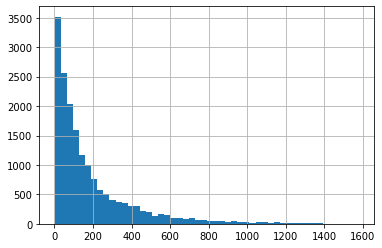

In [57]:
kvart['days_exposition'].hist(bins = 50)
print('Количество пропущенных значений: {:.0f}'.format(kvart[kvart['days_exposition'].isnull()]['total_images'].count()))
# Вероятней всего остальные пропущенные значения неслучайны, либо квартира ещё продаётся,
# либо владелец просто забыл снять объявление после продажи

In [58]:
kvart.duplicated().sum() # Дубликатов нет

0

### Шаг 3. Посчитайте и добавьте в таблицу

Цена квадратного метра.

In [59]:
kvart['price_per_metr'] = kvart['last_price'] / kvart['total_area']
kvart['price_per_metr'] = kvart['price_per_metr'].round(2)

День недели, месяц и год публикации объявления.

In [60]:
kvart['weekday'] = kvart['first_day_exposition'].dt.weekday
kvart['month'] = kvart['first_day_exposition'].dt.month
kvart['year'] = kvart['first_day_exposition'].dt.year

Этаж квартиры.

In [61]:
kvart['floor_type'] = np.where(kvart['floor'] == 1, 'первый', 'другой')
kvart['floor_type'] = np.where(kvart['floor'] == kvart['floors_total'], 'последний', kvart['floor_type'])

Соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [62]:
kvart['living_area_rel'] = kvart['living_area'] / kvart['total_area']
kvart['kitchen_area_rel'] = kvart['kitchen_area_good'] / kvart['total_area']

In [63]:
print(kvart.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
4             2  10000000.0       100.0           2018-06-19      2   
5            10   2890000.0        30.4           2018-09-10      1   
6             6   3700000.0        37.3           2017-11-02      1   

   ceiling_height floors_total  living_area  floor  is_apartment  ...  \
1            2.70           11         18.6      1         False  ...   
2            2.55            5         34.3      4         False  ...   
4            3.03           14         32.0     13         False  ...   
5            2.65           12         14.4      5         False  ...   
6            2.65           26         10.6      6         False  ...   

   ponds_nearest  days_exposition  kitchen_area_good  price_per_metr weekday  \
1            NaN               81               11.0  

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Площадь, цена, количество комнат и высота потолков.

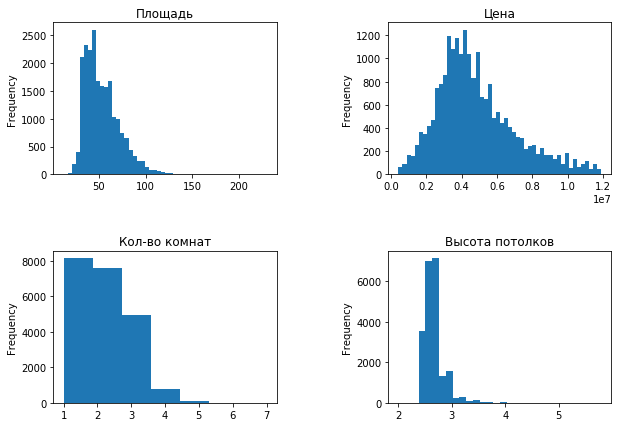

In [64]:
columns = ['total_area', 'last_price', 'rooms', 'ceiling_height']
titles = ['Площадь', 'Цена', 'Кол-во комнат', 'Высота потолков']
bins_number = [50, 50, kvart['rooms'].max(), 30]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10,7))
fig.subplots_adjust(wspace=0.5, hspace = 0.5)
for i in range (len(columns)):
    kvart[columns[i]].plot(kind='hist', bins = bins_number[i], ax =ax[i//2, (i)%2], title=titles[i]);
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c66c54b10>,
      dtype=object)

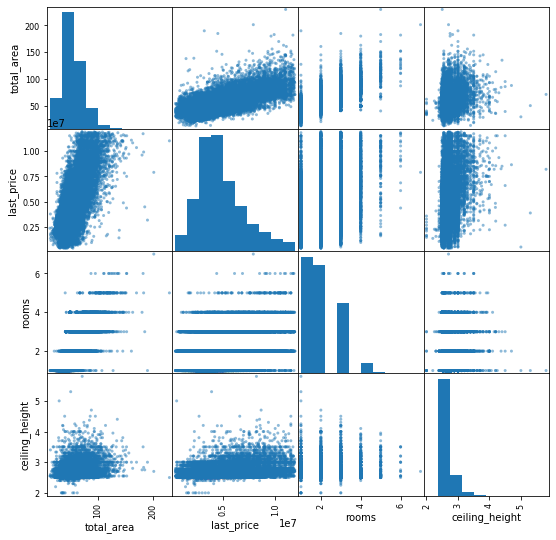

In [65]:
pd.plotting.scatter_matrix(kvart.loc[:,['total_area','last_price','rooms','ceiling_height']], figsize=(9, 9), alpha = 0.5)

*Из распределений выше видно:*

* есть определенная связь между площадью и стоимостью квартиры, которая будет отдельно разобрана ниже,
* прямая связь площади и количества комнат, однако не настолько очевидная, как можно ожидать: есть как одно-, так и пяти-комнатные квартиры площадью 100 метров, а трех- и четырехкомнатные квартиры лежат примерно в одном диапазоне,
* стоимость и количество комнат положительно коррелируют, так как связаны с площадью,
* высота потолков имеет небольшой разброс и почти не связана с другими параметрами (в маленьких квартирах больше разброс высоты потолков просто потому, что их больше, чем больших квартир).

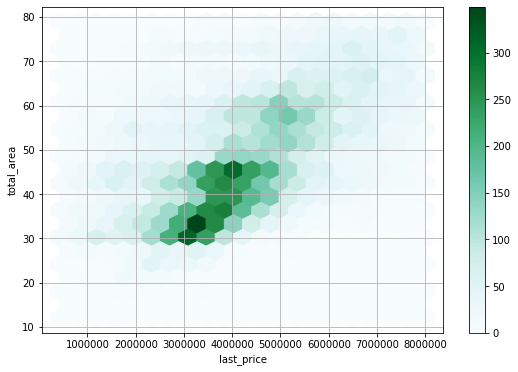

In [66]:
price_qnt = kvart['last_price'].quantile(0.9)
area_qnt = kvart['total_area'].quantile(0.9)
kvart.query('last_price < @price_qnt and total_area < @area_qnt').plot(x='last_price', y='total_area', kind='hexbin', gridsize=20, figsize=(9, 6), sharex=False, grid=True)
# График площади и стоимости квартир с ограничением до 90% квантиля

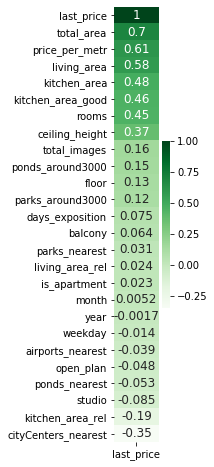

In [67]:
# Доработка, надеюсь сделал то, что требовали.
plt.figure(figsize=(1,8))
sns.heatmap(kvart.corr()[['last_price']].sort_values(by='last_price', ascending=False), cmap="Greens", 
            annot=True, annot_kws={'size':12})

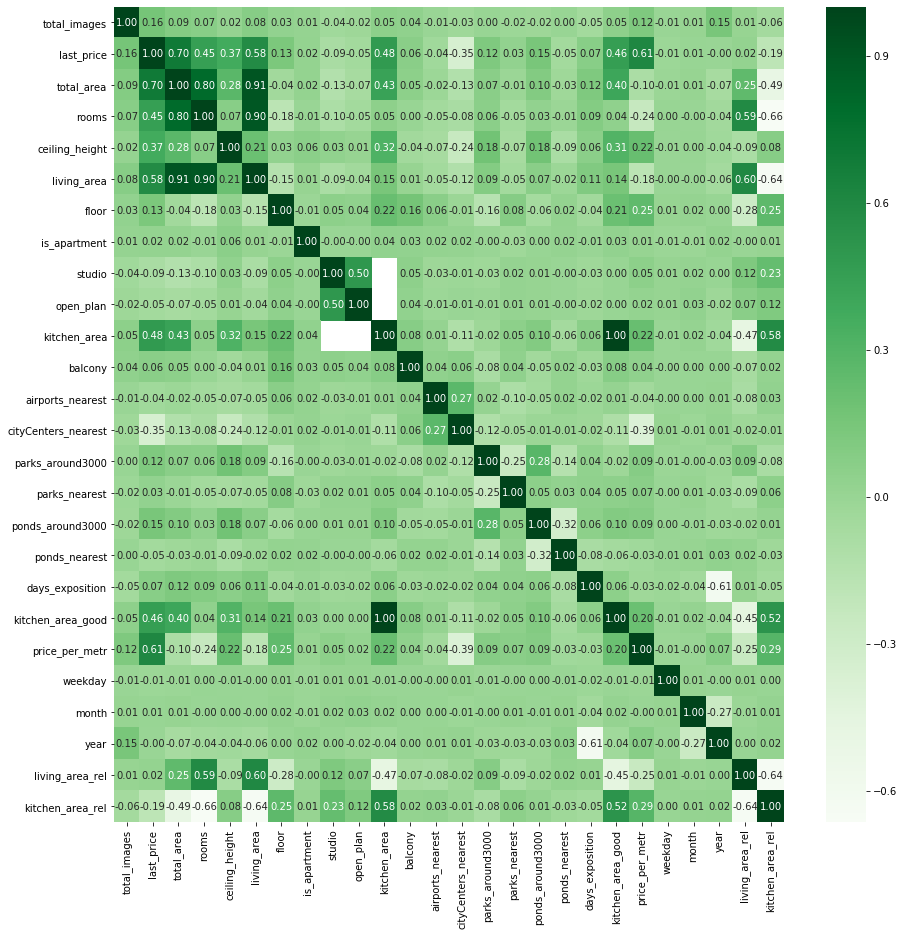

In [68]:
# Для полной картины
plt.figure(figsize=(15,15))
sns.heatmap(kvart.corr(), annot=True, cmap="Greens", fmt='.2f')

*На этом графике видно, что:*

* площадь большинства квартир сосредоточена в пределах от 30 до 50 метров,
* у квартир в любом диапазоне при одинаковой площади стоимость отличается примерно в 1,5 раза,
* есть очевидная связь между стоимостью и площадью квартиры.

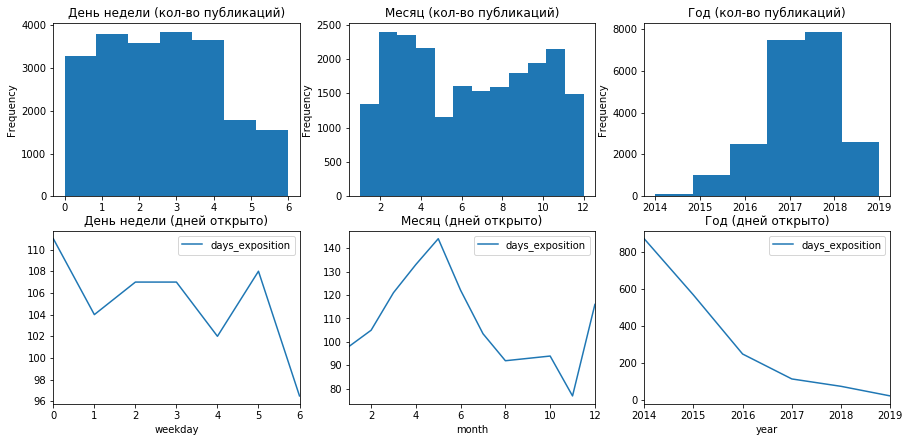

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15,7))
kvart['weekday'].plot(kind='hist', ax=axes[0, 0], bins = 7, title = 'День недели (кол-во публикаций)');
kvart['month'].plot(kind='hist', ax=axes[0, 1], bins = 12, title = 'Месяц (кол-во публикаций)');
kvart['year'].plot(kind='hist', ax=axes[0, 2], bins = 6, title = 'Год (кол-во публикаций)');
kvart.pivot_table(index=['weekday'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 0], title = 'День недели (дней открыто)');
kvart.pivot_table(index=['month'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 1], title = 'Месяц (дней открыто)');
kvart.pivot_table(index=['year'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 2], title = 'Год (дней открыто)');
# В верхней строке день, месяц, год публикации объявления
# В нижней строке медианное время открытия

* По будням открывается больше объявлений чем в выходные, скорее всего продают риелторы.
* Резкое падение в мае, скорее всего связано с кол-вом праздников.
* Объявления, опубликованные в месяцы меньшей активности, закрываются дольше.
* Сервис развивается и публикации снимаются быстрее год за годом.

*Как показано выше, стоимость квартиры положительно коррелирует с ее площадью. Поэтому для оценки факторов влияния на стоимость нужно сравнивать стоимость квадратного метра площади в зависимости от других параметров:*
*(от стоимости отрезано по 10% значений сверху и снизу для наглядности графиков)*

In [70]:
price_per_metr_qntl = kvart['price_per_metr'].quantile(0.9)
price_per_metr_qntu = kvart['price_per_metr'].quantile(0.1)
total_area_qnt = kvart['total_area'].quantile(0.9)
cityCenter_nearest_qnt = kvart['cityCenters_nearest'].quantile(0.9)

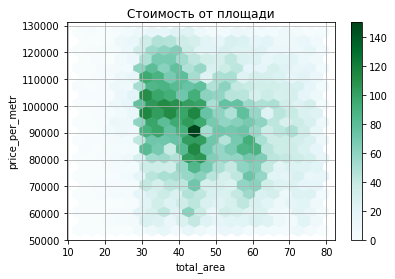

In [71]:
(kvart.query('price_per_metr < @price_per_metr_qntl and price_per_metr > @price_per_metr_qntu and total_area < @total_area_qnt')
 .plot(x='total_area', y='price_per_metr', kind='hexbin', gridsize=20, sharex=False, grid=True, title = 'Стоимость от площади'))

Чем больше площадь квартиры, тем ниже стоимость квадратного метра. Видны пики количества квартир (а значит, и разброса стоимости) на 30, 45 и 60 метрах, которые, видимо, являются средними для стандартных планировок. Чем больше площадь, тем меньше квартир и, соответственно, ниже разброс значений.

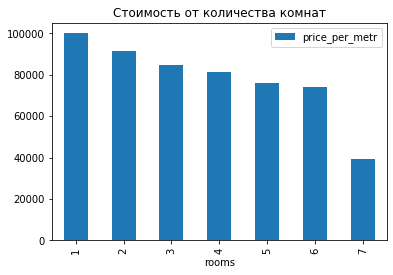

In [72]:
(kvart.pivot_table(index=['rooms'], values='price_per_metr', aggfunc='median')
 .plot(kind='bar', title = 'Стоимость от количества комнат'))
# Чем больше комнат, тем ниже медианная стоимость квадратного метра

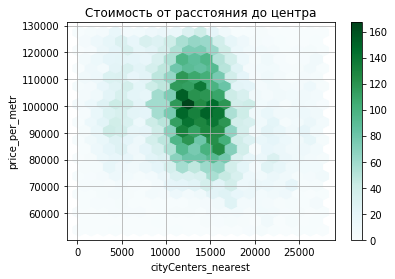

In [73]:
(kvart.query('price_per_metr < @price_per_metr_qntl and price_per_metr > @price_per_metr_qntu and cityCenters_nearest < @cityCenter_nearest_qnt')
 .plot(x='cityCenters_nearest', y='price_per_metr', kind='hexbin', gridsize=20, sharex=False, grid=True, title = 'Стоимость от расстояния до центра'))
# По расстоянию от центра виден нисходящий тренд, но неочевидный, скорее всего влияют другие факторы.

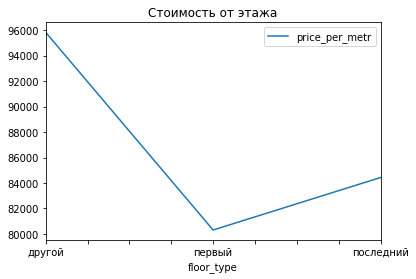

In [74]:
kvart.pivot_table(index=['floor_type'], values='price_per_metr', aggfunc='median').plot(kind='line', title = 'Стоимость от этажа')
# На первом этаже квартиры ожидаемо дешевле

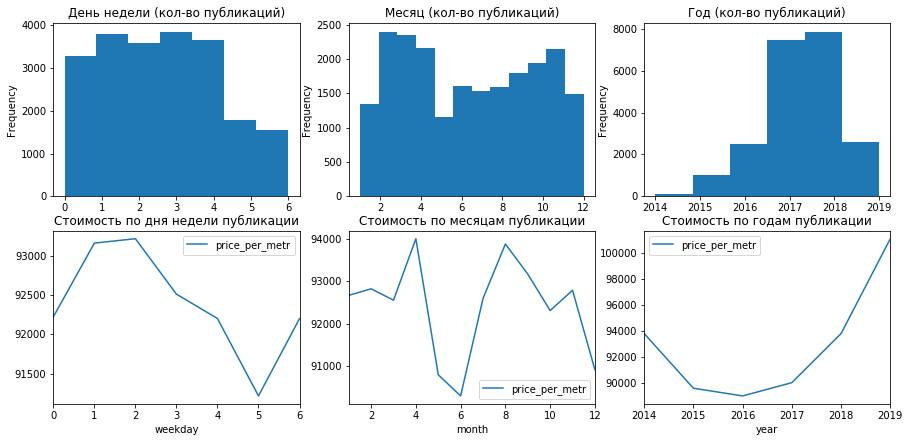

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15,7))
kvart['weekday'].plot(kind='hist', ax=axes[0, 0], bins = 7, title = 'День недели (кол-во публикаций)');
kvart['month'].plot(kind='hist', ax=axes[0, 1], bins = 12, title = 'Месяц (кол-во публикаций)');
kvart['year'].plot(kind='hist', ax=axes[0, 2], bins = 6, title = 'Год (кол-во публикаций)');
kvart.pivot_table(index=['weekday'], values='price_per_metr', aggfunc='median').plot(kind='line', ax=axes[1, 0], title = 'Стоимость по дня недели публикации');
kvart.pivot_table(index=['month'], values='price_per_metr', aggfunc='median').plot(kind='line', ax=axes[1, 1], title = 'Стоимость по месяцам публикации');
kvart.pivot_table(index=['year'], values='price_per_metr', aggfunc='median').plot(kind='line', ax=axes[1, 2], title = 'Стоимость по годам публикации');
# Средняя стоимость квадратного метра почти не отличается, не смотря на разное кол-во публикаций в разные дни/месяцы/годы

In [76]:
kvart_pivot_table = kvart.pivot_table(index = 'locality_name', values = 'price_per_metr', aggfunc=['count', 'mean'])
kvart_pivot_table.columns = ['count', 'mean']
kvart_pivot_table = kvart_pivot_table.sort_values('count', ascending = False).head(10)
kvart_pivot_table
#самая высокая стоимость
kvart_pivot_table[kvart_pivot_table['mean']==kvart_pivot_table['mean'].max()]
#самая низкая стоимость
kvart_pivot_table[kvart_pivot_table['mean']==kvart_pivot_table['mean'].min()]

,count,mean
locality_name,,
Выборг,236,57932.878771


In [76]:
#(kvart.pivot_table(index='locality_name', values='price_per_metr', aggfunc=['count', 'median'])
 #.sort_values(by=('count','price_per_metr'),ascending = False).round().head(10))
# Топ 10 по кол-ву объявлений

In [77]:
#(kvart.pivot_table(index='locality_name', values='price_per_metr', aggfunc=['count', 'median'])
 #3.sort_values(by=('median','price_per_metr'),ascending = False).round().head(10))
# Топ 10 по медианной стоимости квадратного метра

In [78]:
#(kvart.pivot_table(index='locality_name', values='price_per_metr', aggfunc=['count', 'median'])
 #.sort_values(by=('median','price_per_metr')).round().head(10))
# Последние 10 по стоимости квадратного метра

*Выводы из рейтингов населенных пунктов:*

* Наибольшее количество объявлений и наивысшая медианная стоимость в СПб.
* Среди населенных пунктов с наинизшей стоимостью различные маленькие пункты с 1-3 объявлениями, то есть хвост данных.
* Update: Самая низкая медианная стоимость с приличным кол-вом объявлений в Выборге.

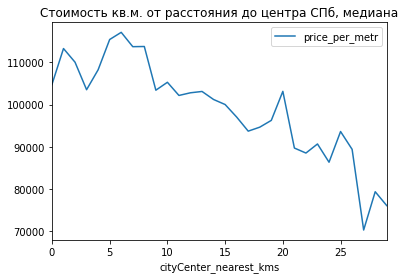

In [79]:
kvart['cityCenter_nearest_kms'] = (kvart['cityCenters_nearest']/1000).round()

(kvart[kvart['locality_name'] == 'Санкт-Петербург']
 .pivot_table(index=['cityCenter_nearest_kms'], values='price_per_metr', aggfunc='median')
 .plot(kind='line', title = 'Стоимость кв.м. от расстояния до центра СПб, медиана')) 

Наибольшая стоимость квартир в СПб в пределах 8 км от центра города.

In [80]:
kvart_spb = kvart.query('locality_name == "Санкт-Петербург"')
kvart_spb_cntr = kvart.query('locality_name == "Санкт-Петербург" and cityCenter_nearest_kms <= 8')

*Анализ квартир в центре Петербурга.*

Сравним два графика, для центра СПб и для всего города с пригородами.
Сравнивать будем по 4 параметрам: цена, площадь, количество комнат, высота потолков.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7676e4e950>,
      dtype=object)

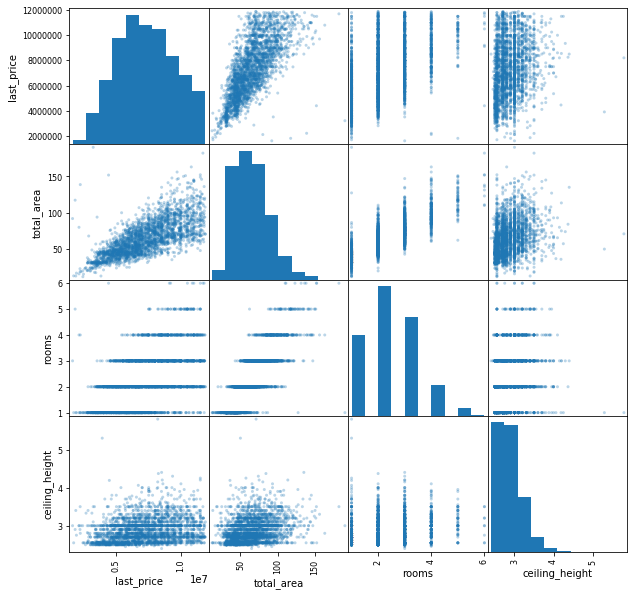

In [81]:
pd.plotting.scatter_matrix(kvart_spb_cntr.loc[:,['last_price','total_area','rooms','ceiling_height']], 
                           figsize=(10, 10), alpha = 0.3)
# Это центр СПб

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f767d619b10>,
      dtype=object)

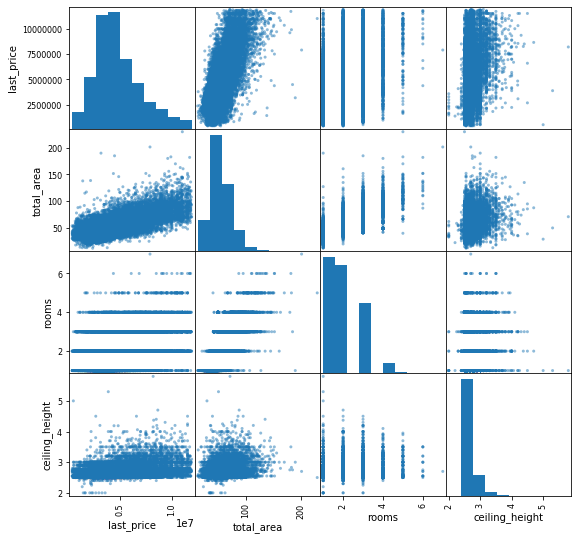

In [82]:
pd.plotting.scatter_matrix(kvart.loc[:,['last_price','total_area','rooms','ceiling_height']], figsize=(9, 9), alpha = 0.5)
# Это весь СПб с пригородами

In [83]:
kvart_spb_cntr.loc[:,['last_price','total_area','rooms','ceiling_height']].corr()

,last_price,total_area,rooms,ceiling_height
last_price,1.000000,0.702012,0.488494,0.217626
total_area,0.702012,1.000000,0.809056,0.276776
rooms,0.488494,0.809056,1.000000,0.215660
ceiling_height,0.217626,0.276776,0.215660,1.000000


In [84]:
kvart.loc[:,['last_price','total_area','rooms','ceiling_height']].corr()

,last_price,total_area,rooms,ceiling_height
last_price,1.000000,0.696995,0.450040,0.371381
total_area,0.696995,1.000000,0.802771,0.275251
rooms,0.450040,0.802771,1.000000,0.072809
ceiling_height,0.371381,0.275251,0.072809,1.000000


* В центре кол-во комнат более явно коррелирует с площадью;
* В центре нет дешевых просторных квартир, все дешевые квартиры меньше 50 кв.м., а разброс по площади есть только у дорогих квартир;
* В центре гораздо меньше бюджетного жилья;
* В центре более высокие потолки: заметна доля квартир с потолком выше 3 метров.

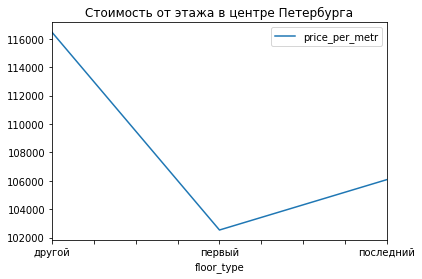

In [85]:
(kvart_spb_cntr.pivot_table(index=['floor_type'], values='price_per_metr', aggfunc='median')
 .plot(kind='line', title = 'Стоимость от этажа в центре Петербурга'))
# Стоимость первого этажа ниже как и в целом по городу

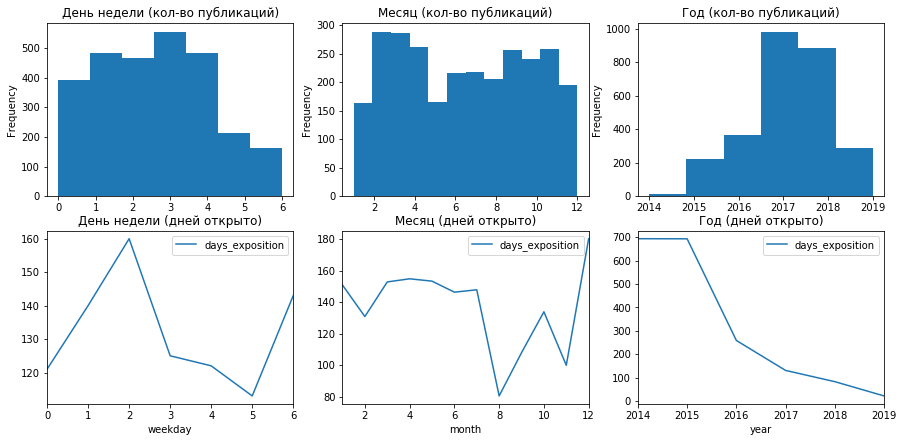

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15,7))
kvart_spb_cntr['weekday'].plot(kind='hist', ax=axes[0, 0], bins = 7, title = 'День недели (кол-во публикаций)');
kvart_spb_cntr['month'].plot(kind='hist', ax=axes[0, 1], bins = 12, title = 'Месяц (кол-во публикаций)');
kvart_spb_cntr['year'].plot(kind='hist', ax=axes[0, 2], bins = 6, title = 'Год (кол-во публикаций)');
kvart_spb_cntr.pivot_table(index=['weekday'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 0], title = 'День недели (дней открыто)');
kvart_spb_cntr.pivot_table(index=['month'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 1], title = 'Месяц (дней открыто)');
kvart_spb_cntr.pivot_table(index=['year'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 2], title = 'Год (дней открыто)');

*Распределение количества публикаций в центре такое же, как и везде, с чуть более хаотичным распределением за счет меньшего количества объявлений. Однако видно, что время, которое объявление бюыло открыто, выше для квартир в центре города, чем в целом.*

### Шаг 5. Общий вывод

Данные обработаны, проверены, дополнены показателями и проанализированы для всей популяции, только для Петербурга и центра Петербурга.
Объявления публикуются чаще в будние дни и месяцы свободные от праздников и отпусков. В менее активные месяцы и дни средняя стоимость на 3-4% ниже стоимости в более активные периоды. Время жизни объявления отличается в 1,5 раза в зависимости от дня недели публикации (что можно считать случайностью, учитывая среднее в 106 дней = 15 недель), и больше чем в 2 раза в зависимости от месяца публикации. В итоге, в более активные месяцы(хотя размещается больше объявлений по более высокой цене) они еще и закрываются быстрее. Среднее время от публикации до закрытия объявления составляет 101 день в Петербурге, 106 за его пределами, но в центре города оно значительно выше - 132 дня, так как (предположительно) здания нетиповые и более дорогие.
Анализ показателей по годам не очень логичен, так как с увеличением количества объявлений на Яндекс.Недвижимости все показатели изменяются в несколько раз.
Центр города для целей анализа определен радиусом в 8 км.

Другие особенности квартир в центре Петербурга:

- средняя площадь выше за счет отсутствия маленьких квартир,
- стоимость квадратного метра (112 тыс.руб.) немного выше, чем в Петербурге в целом (102 тыс. руб.) и в городе с пригородами (93 тыс. руб.),
- медианная стоимость квартиры значительно (на 64%) выше, чем с пригородами;
в центре СПб в домах высокие потолки и малое кол-во этажей.

Влияние факторов на стоимость квартиры (квадратного метра):

- этаж (первый и последний - дешевле);
- населенный пункт (самые дорогие, кроме Петербурга, - Зеленогорск, Пушкин, Сестрорецк);
- расстояние от центра города напрямую не влияет на стоимость: внутри Петербурга оно имеет определяющее значение, начиная с 8 км от центра, для остальных мест важен именно населенный пункт;
- площадь (чем больше квартира, тем дешевле квадратный метр);
- количество комнат (аналогично).